In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
import pylab as plb
plb.rcParams['pdf.fonttype'] = 42 #allows text in saved .pdf files to be edited in illustrator
recalc_means = False #recalculate the groupwise mean stats set to False to load from file

Populating the interactive namespace from numpy and matplotlib


In [2]:
import h5py
epoch_db = h5py.File('../02_imaging_post_processing/epoch_db_nnls_fits_bk_sub_F.hdf5','a')

In [3]:
data = dict()
data['exp_names'] = np.array(epoch_db['exp_names'])
data['fly_numbers'] = np.array(epoch_db['fly_numbers'])
data['genotypes'] = np.array(epoch_db['genotypes'])
data['signal_data'] = np.array(epoch_db['signal_data'])
data['signal_names'] = np.array(epoch_db['signal_names'])
data['trial_names'] = np.array(epoch_db['trial_names'])
data['flt_samples'] = np.array(epoch_db['flt_samples'])

In [5]:
# function to get the timebase using the trial name (yaw_left)
def get_xio(trial_name):
    xi = np.linspace(0,23,1150)
    #print trial_name
    if trial_name in ['ascending','descending','yaw_left','yaw_right','progressive','regressive']:
        xi -= 10.0
    if 'pth_roll' in trial_name:
        xi -= 7.0
    if 'flight' in trial_name:
        xi -= 5.0
    else:
        return xi
    return xi

In [6]:
-

In [7]:
import group_data as gd
trial_types = set(data['trial_names'])
test_set = list(trial_types.difference(['flight_starts','flight_stops','stripe_fix']))
fly_set = set(gd.GMR22H05_list) | set(gd.GMR22H05_pr_list) | set(gd.GMR22H05_prc_list)
#fly_set = set(gd.GMR40D04_pr_list)

In [8]:
#mask out the data so only the trial types in test_set will be included
mask = np.zeros(shape(data['trial_names'])[0]).astype(bool)
for trial_name in test_set:
    mask = mask | (data['trial_names'] == trial_name)

#now mask out the data to only include the flys in fly_set
fly_mask = np.zeros(shape(data['trial_names'])[0]).astype(bool)
for fly in fly_set:
    fly_mask = fly_mask | (data['fly_numbers'] == fly)
mask = mask & fly_mask
#data['trial_names'] == list(test_set)[0])

In [9]:
import cPickle
if recalc_means:
    means = fly_means(data,mask)
    with open('mean_dict_22H05.cpkl','wb') as fi: cPickle.dump(means,fi)
else:
    with open('mean_dict_22H05.cpkl','rb') as fi: means = cPickle.load(fi)

In [10]:
trial_to_label = dict()
[trial_to_label.update({tname:tname}) for tname in trial_types]

[trial_to_label.update({tname:'PR' + tname.split('_')[-1]}) 
    for tname in trial_types if 'pth_roll' in tname]

trial_to_label['step_roll_yaw_000'] = 'RL'#\n00'
trial_to_label['step_roll_yaw_090'] = 'YR'#\n90'
trial_to_label['step_roll_yaw_180'] = 'RR'#\n180'
trial_to_label['step_roll_yaw_270'] = 'YL'#\n270'

trial_to_label['ascending'] = 'ASC'
trial_to_label['descending'] = 'DEC'
trial_to_label['progressive'] = 'PRO'
trial_to_label['regressive'] = 'REG'

trial_to_label['pth_roll_0'] = 'PU'#\n00'
trial_to_label['pth_roll_90'] = 'RR'#\n90'
trial_to_label['pth_roll_180'] = 'PD'#\n180'
trial_to_label['pth_roll_270'] = 'RL'#\n270'

trial_to_label['yaw_left'] = 'YR'
trial_to_label['yaw_right'] = 'YL'

In [11]:
trial_to_color = dict()
red = '#82182B'
blue = '#2166AC'

trial_to_color['ascending'] = blue
trial_to_color['descending'] = red
trial_to_color['progressive'] = blue
trial_to_color['regressive'] = red
trial_to_color['yaw_left'] = blue
trial_to_color['yaw_right'] = red
trial_to_color['pth_roll_180']= blue
trial_to_color['pth_roll_0'] = red
trial_to_color['pth_roll_90'] = blue
trial_to_color['pth_roll_270'] = red

In [24]:
### This plots figure 3b - ensamble responses to motion around the cardinal axes. 
#signal_plot_list = ['Ph1','Ph0', 'wb_frequency','b1','b2','b3','i1','i2','iii1','iii3','iii24','hg1','hg2','hg3','hg4','tpd','tpv','ttm']
sig_list = ['Ph1','b1','b2','b3','i1','i2','iii1','iii3','iii24','hg1','hg2','hg3','hg4','tpd','tpv','ttm']
trial_list = [['ascending','descending'],['progressive','regressive'],['yaw_left','yaw_right'],['pth_roll_180','pth_roll_0'],
                  ['pth_roll_90','pth_roll_270']]

lookup_ybound = {'Ph1':(-10,10),
                 'Ph0':(-10,10),
                 'wb_frequency':(-10,10),
                 'b1':(-0.1,0.1),
                 'b2':( 0.0,0.2),
                 'b3':(-0.2,0.2),
                 'i1':(0.0,0.5),
                 'i2':(0.0,0.5),
                 'iii1':(0.0,0.3),
                 'iii3':(-1,1),
                 'iii24':(-0.1,0.1),
                 'hg1':(0.0,3.0),
                 'hg2':(0.0,3.0),
                 'hg3':(-0.5,0.5),
                 'hg4':(-0.5,0.5),
                 'tpd':(-0.1,0.1),
                 'tpv':(-0.1,0.1),
                 'ttm':(-0.01,0.01)}

def resample_ts_ci(dataset,nsamples = 100):
    #print shape(dataset)
    synthetic_means = np.zeros([nsamples,shape(dataset)[1]])
    idxs = np.arange(shape(dataset)[0])
    for i in range(nsamples):
        synthetic_means[i,:] = np.mean(dataset[np.random.choice(idxs,size = len(idxs)),:],axis = 0)
    ub = np.nanpercentile(synthetic_means,97.5,axis = 0)
    lb = np.nanpercentile(synthetic_means,2.5,axis = 0)
    mean = np.mean(dataset,axis =0)
    return ub,lb,mean

def plot_mean_std(col,row):
    signal = sig_list[row]
    for trial in trial_list[col]:
        xi = get_xio(trial)
        time_mask = (xi > -2) & (xi < 4.5)
        color = trial_to_color[trial]
        ub,lb,md = resample_ts_ci(np.array(means[signal][trial].values()))
        ub,lb,md = [gd.signal_plot_info[signal]['transform'](s) for s in [ub,lb,md]]
        fill_between(xi[time_mask],lb[time_mask],ub[time_mask],color = color,alpha = 0.6,clip_on = False,lw = 0)
        plot(xi[time_mask],md[time_mask],clip_on = False,color = color)
        
pkwa = dict()
pkwa['rows'] = len(sig_list)
pkwa['cols'] = len(trial_list)

pkwa['col_epochs'] = [(0,3) for i in range(pkwa['cols'])]
pkwa['col_epochs_kwargs'] = [{'alpha':0.2,'color':'b','lw':None} for i in range(pkwa['cols'])]

pkwa['row_epochs'] = [None for j in range(pkwa['rows'])]

pkwa['col_labels_bottom'] = [None for i in range(pkwa['cols'])] 
pkwa['col_labels_bottom'][-1] = 'time (s)'

pkwa['row_labels_left'] = [gd.signal_plot_info[sig]['ax_label'] for sig in sig_list]
pkwa['col_labels_top'] = [trial_to_label[trial[0]] + '\n' +trial_to_label[trial[1]] for trial in trial_list]
pkwa['row_labels_right'] = [None for j in range(pkwa['rows'])]

pkwa['ybounds'] = [lookup_ybound[s] for s in sig_list]
pkwa['xbounds'] = [(-2,4) for i in range(pkwa['cols'])]

pkwa['ytick_numbers'] = [3 for j in range(pkwa['rows'])]
pkwa['xtick_numbers'] = [4 for i in range(pkwa['cols'])]

pkwa['show_spines_left'] = False
pkwa['show_spines_top'] = False

pkwa['show_spines_right'] = [True for j in range(pkwa['rows'])]

pkwa['show_spines_bottom'] = [False for j in range(pkwa['cols'])]
pkwa['show_spines_bottom'][-1] = True
pkwa['figsize'] = (6,14)
pkwa['plot_panel_function'] = plot_mean_std

import plotfuncs as pf
reload(pf)
pf.plot_data_matrix(**pkwa)

In [31]:
def get_pvalue_for_coef(signal,condition):
    """Calculate a matrix of p-values for the responses to motion around the cardinal axes."""
    from scipy.stats import ttest_1samp
    xi = get_xio(condition)
    selection = ((xi>0) & (xi<3))
    dta_mtrx = np.array(meds[signal][condition].values())
    mvals = np.mean(dta_mtrx[:,selection],axis = 1)
    #print shape(mvals)
    mn = np.mean(mvals)
    return ttest_1samp(mvals,0)[1],mn,mvals

In [32]:
# load up a dictionary with the p-values for each cardinal direction
# the data are sorted by direction
signal_pvalue_dict = dict()
for signal in signal_plot_list:
    signal_pvalue_dict[signal] = dict()
    for trial in trial_plot_list:
        #print trial
        pv,mn,mvals = get_pvalue_for_coef(signal,trial[0])
        signal_pvalue_dict[signal][trial[0]] = pv * mn/abs(mn)
        pv,mn,mvals = get_pvalue_for_coef(signal,trial[1])
        signal_pvalue_dict[signal][trial[1]] = pv * mn/abs(mn)
        #print get_pvalue(signal,trial[0])

/home/psilentp/anaconda/lib/python2.7/site-packages/matplotlib/backends/backend_pdf.py:2264: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  different = bool(ours != theirs)


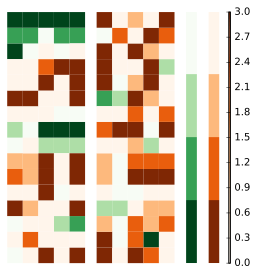

In [33]:
#Make a plot of the response p-values. Sorted by behavioral response polarity
from matplotlib.colors import LogNorm
fig = figure(figsize = (4,4.5))
gs = gridspec.GridSpec(100,100)

#Set up the axes
amp_inc_ax = fig.add_subplot(gs[:100,:35])
amp_dec_ax = fig.add_subplot(gs[:100,40:75])
amp_inc_key_ax = fig.add_subplot(gs[:100,80:85])
amp_dec_key_ax = fig.add_subplot(gs[:100,90:95])
pscale_lbl_ax = fig.add_subplot(gs[:100,95:100])

#Plot the stimuli with decreases in stroke amplitude
plot_mtrx = list()
for c_idx, c_name in enumerate(['ascending','progressive','yaw_left','pth_roll_180','pth_roll_90']):
    plot_mtrx.append(list())
    for s_idx,s_name in enumerate(['Ph1','b1','b2','b3','i1','i2','iii1','iii3','iii24','hg1','hg2','hg3','hg4','tpd','tpv','ttm']):
        plot_mtrx[c_idx].append(signal_pvalue_dict[s_name][c_name])

from matplotlib.colors import LogNorm
axes(amp_inc_ax)
plot_mtrx = np.array(plot_mtrx)

positive_mask = np.array(plot_mtrx) > 0
negative_mask = np.array(plot_mtrx) < 0 

plot_mtrx1 =  (plot_mtrx > -0.05).astype(int)*-1
plot_mtrx1 += (plot_mtrx > -0.01).astype(int)*-1
plot_mtrx1 += (plot_mtrx > -0.001).astype(int)*-1
plot_mtrx1 = rot90(ma.masked_array(plot_mtrx1,mask = positive_mask))

plot_mtrx2 = (plot_mtrx < 0.05).astype(int)
plot_mtrx2 += (plot_mtrx < 0.01).astype(int)
plot_mtrx2 += (plot_mtrx < 0.001).astype(int)
plot_mtrx2 = rot90(ma.masked_array(plot_mtrx2,mask = negative_mask))

pcolormesh(plot_mtrx1*-1,cmap = cm.Greens,vmin = 0,vmax = 3)
pcolormesh(plot_mtrx2,cmap = cm.Oranges,vmin = 0,vmax = 3)
kill_spines()

#Plot the stimuli with increases in stroke amplitude
plot_mtrx = list()
for c_idx, c_name in enumerate(['descending','regressive','yaw_right','pth_roll_0','pth_roll_270']):
    plot_mtrx.append(list())
    for s_idx,s_name in enumerate(['Ph1','b1','b2','b3','i1','i2','iii1','iii3','iii24','hg1','hg2','hg3','hg4','tpd','tpv','ttm']):
        plot_mtrx[c_idx].append(signal_pvalue_dict[s_name][c_name])
axes(amp_dec_ax)
plot_mtrx = np.array(plot_mtrx)

positive_mask = np.array(plot_mtrx) > 0
negative_mask = np.array(plot_mtrx) < 0 

plot_mtrx1 =  (plot_mtrx > -0.05).astype(int)*-1
plot_mtrx1 += (plot_mtrx > -0.01).astype(int)*-1
plot_mtrx1 += (plot_mtrx > -0.001).astype(int)*-1
plot_mtrx1 = rot90(ma.masked_array(plot_mtrx1,mask = positive_mask))

plot_mtrx2 = (plot_mtrx < 0.05).astype(int)
plot_mtrx2 += (plot_mtrx < 0.01).astype(int)
plot_mtrx2 += (plot_mtrx < 0.001).astype(int)
plot_mtrx2 = rot90(ma.masked_array(plot_mtrx2,mask = negative_mask))

pcolormesh(plot_mtrx1*-1,cmap = cm.Greens,vmin = 0,vmax = 3,lw = 10.0)
pcolormesh(plot_mtrx2,cmap = cm.Oranges,vmin = 0,vmax = 3)
kill_spines()

axes(pscale_lbl_ax)
kill_spines()
colorbar(aspect = 'auto')

axes(amp_inc_key_ax)
imshow(np.array([linspace(1.0,0.0,4)]).T,aspect = 'auto',interpolation='nearest',cmap = cm.Greens_r)
kill_spines()

axes(amp_dec_key_ax)
imshow(np.array([linspace(1.0,0.0,4)][::-1]).T,aspect = 'auto',interpolation='nearest',cmap = cm.Oranges_r)
kill_spines()
savefig('cardinal_pval.pdf')